In [1]:
from IPython.display import clear_output

!wget -O event_log.csv https://www.dropbox.com/scl/fi/ejaakqgmhn7av7skwtkmx/Production_Data.csv?rlkey=2ps7e8g9lxf7mczlmupdw5t9h&dl=1

clear_output()
print("Log loaded.")

Log loaded.


In [2]:
!pip install mpvis
!pip install pm4py

clear_output()
print("Packages installed.")

Packages installed.


In [3]:
import mpvis
from mpvis import mddrt
from mpvis import mpdfg
import pm4py
import pandas as pd
from datetime import datetime
from IPython.display import SVG, display
clear_output()

In [4]:
event_log = pd.read_csv('event_log.csv', sep = ',')

log_format = {'case:concept:name': 'Case ID',
              'concept:name': 'Activity',
              'time:timestamp': 'Complete Timestamp',
              'start_timestamp': 'Start Timestamp',
              'org:resource': 'Worker ID',
              'cost:total': ''}

event_log = mpvis.log_formatter(event_log.copy(), log_format)

In [5]:
print("Case count: " + str(len(set(event_log['case:concept:name']))))
print("Variant count: " + str(len(pm4py.stats.get_variants(event_log.copy()))))
print("Event count: " + str(len(event_log['case:concept:name'])))
print("Activity count: " + str(len(set(event_log['concept:name']))))

Case count: 225
Variant count: 221
Event count: 4543
Activity count: 55


In [6]:
mpdfg_discovery_start = datetime.now()

dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(event_log.copy())

mpdfg_discovery_end = datetime.now()

print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 2.197119 seconds.


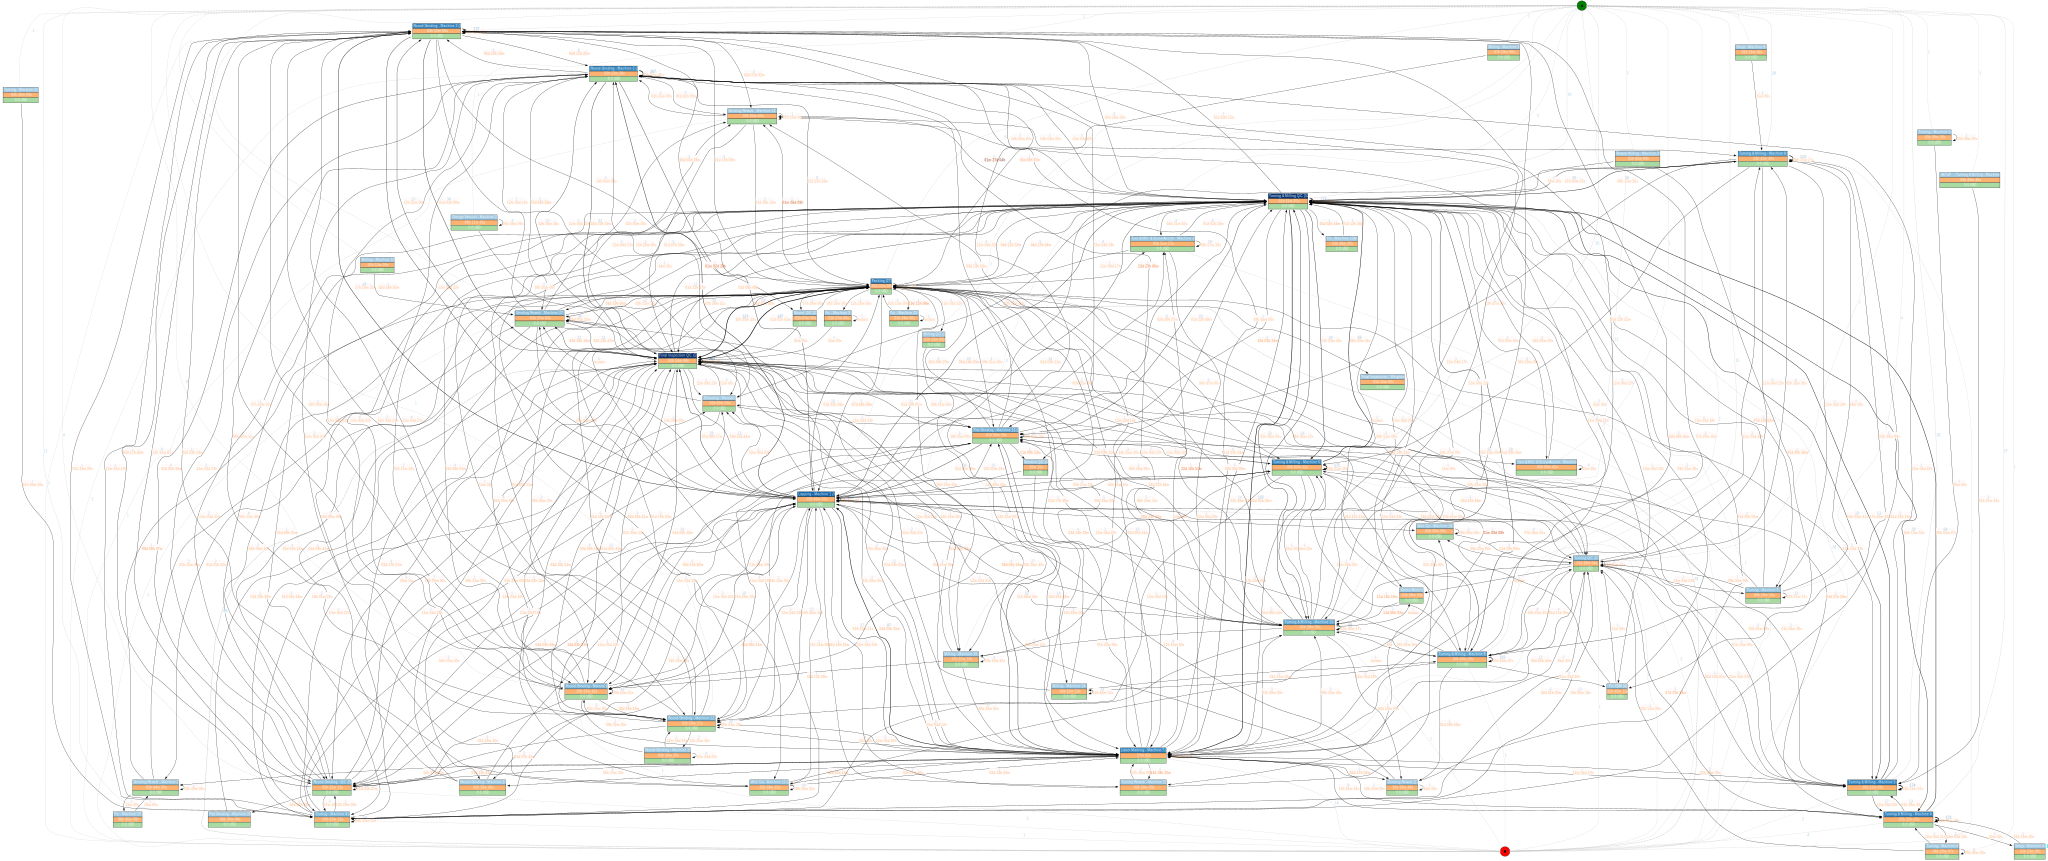

MP-DFG visualization time: 20.238606 seconds.


In [7]:
mpdfg_visualization_start = datetime.now()

mpdfg.view_multi_perspective_dfg(dfg, start_activities, end_activities)

mpdfg_visualization_end = datetime.now()

print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")

In [8]:
mddrt_discovery_start = datetime.now()

drt = mddrt.discover_multi_dimensional_drt(event_log.copy())

mddrt_discovery_end = datetime.now()

print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")

Calculating log mandatory activities: 


100%|██████████| 225/225 [00:00<00:00, 849.93it/s]


Calculating log metrics: 


100%|██████████| 225/225 [00:00<00:00, 540.66it/s]


Building Tree Cases:


100%|██████████| 225/225 [00:02<00:00, 91.79it/s]


Building Tree Graph:


100%|██████████| 225/225 [00:00<00:00, 904.48it/s]

MD-DRT discovery time: 3.438716 seconds.


In [9]:
mddrt_visualization_start = datetime.now()

mddrt.view_multi_dimensional_drt(drt)

mddrt_visualization_end = datetime.now()

print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

Output hidden; open in https://colab.research.google.com to view.

In [10]:
print("MP-DFG discovery time: " + str((mpdfg_discovery_end - mpdfg_discovery_start).total_seconds()) + " seconds.")
print("MP-DFG visualization time: " + str((mpdfg_visualization_end - mpdfg_visualization_start).total_seconds()) + " seconds.")
print("MD-DRT discovery time: " + str((mddrt_discovery_end - mddrt_discovery_start).total_seconds()) + " seconds.")
print("MD-DRT visualization time: " + str((mddrt_visualization_end - mddrt_visualization_start).total_seconds()) + " seconds.")

MP-DFG discovery time: 2.197119 seconds.
MP-DFG visualization time: 20.238606 seconds.
MD-DRT discovery time: 3.438716 seconds.
MD-DRT visualization time: 18.176319 seconds.


In [11]:
# A copy of the original log is used to allow comparing the processed and original logs
processed_log = event_log.copy()

In [12]:
# The activities of the original log concatenate the actual activity with the machine that was associated to the activity (e.g., 'Turning & Milling - Machine 10')
# To reduce the number of activities, the associated machine part is removed
processed_log['concept:name'] = processed_log['concept:name'].str.split(' - ').str[0]

# Moreover, similar activities are renamed to a unique name (e.g., turning and milling activities are renamed as 'Turning & Milling')
processed_log['concept:name'] = processed_log['concept:name'].apply(lambda x : 'Turning & Milling' if (x == 'Turning') or (x == 'Milling') else x)
processed_log['concept:name'] = processed_log['concept:name'].apply(lambda x : 'Grinding' if 'Grinding' in x else x)
processed_log['concept:name'] = processed_log['concept:name'].apply(lambda x : 'Final Inspection' if 'Final Inspection' in x else x)

print("Activity count before: " + str(len(set(event_log['concept:name']))))
print("Activity count after: " + str(len(set(processed_log['concept:name']))))

Activity count before: 55
Activity count after: 22


In [13]:
# The original log contains several cases that seem to be incomplete (e.g., they do not start or end with a valid activity)
# Only cases that start with 'Turning & Milling' and that end with 'Packing' or 'Final Inspection' will be considered
processed_log = pm4py.filter_start_activities(processed_log, ['Turning & Milling'])
processed_log = pm4py.filter_end_activities(processed_log, ['Packing', 'Final Inspection'])

# Several spare parts are included in the event log. However, only a few of them are considered in multiple cases
# Only the three most frequent spare parts, 'Ballnut', 'Cable Head', and 'Spur Gear', will be considered
processed_log = pm4py.filter_event_attribute_values(processed_log, 'Part Desc.', ['Ballnut', 'Cable Head', 'Spur Gear'])

print("Case count before: " + str(len(set(event_log['case:concept:name']))))
print("Case count after: " + str(len(set(processed_log['case:concept:name']))))

Case count before: 225
Case count after: 77


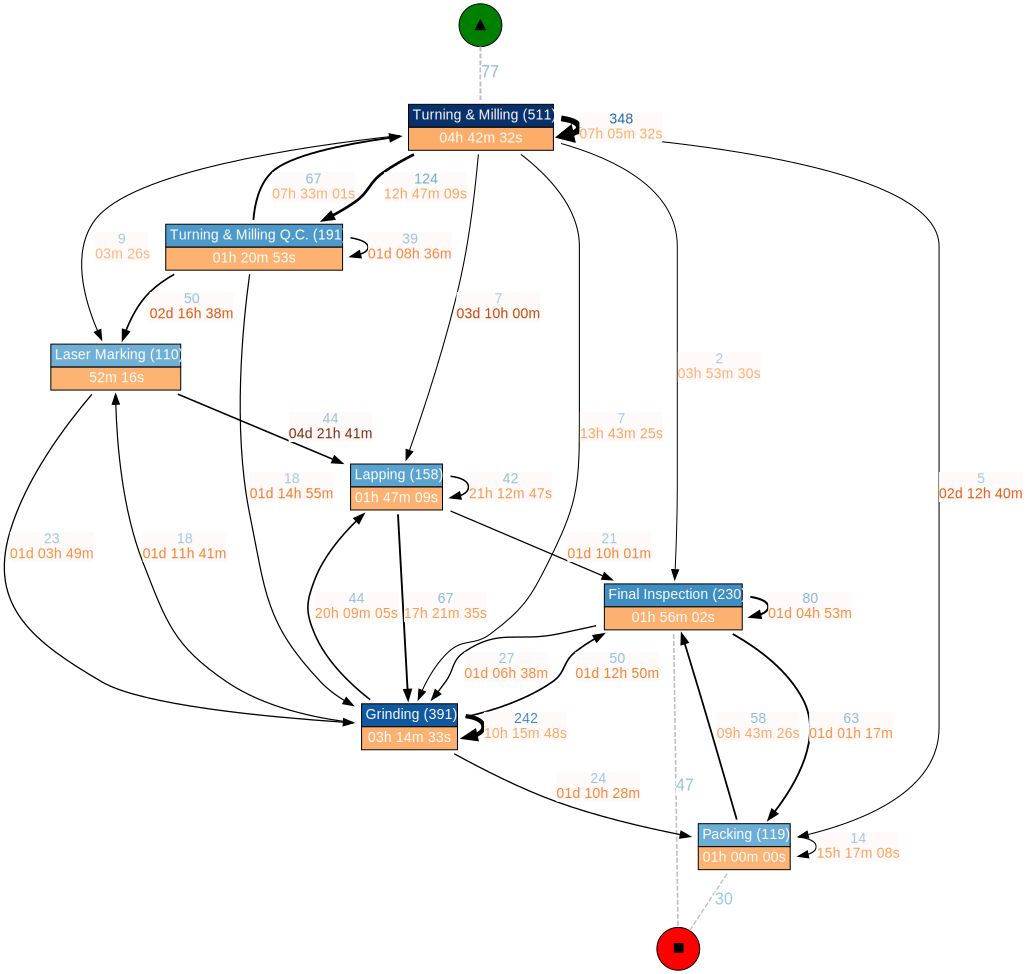

In [14]:
dfg, start_activities, end_activities = mpdfg.discover_multi_perspective_dfg(processed_log.copy())

# The frequency of several activities is below 10, so they are excluded from the visualization
filtered_dfg = mpdfg.filter_multi_perspective_dfg_activities(65, dfg, start_activities, end_activities)

# The frequency of most paths is not high, so only the most common ones are considered
filtered_dfg = mpdfg.filter_multi_perspective_dfg_paths(40, filtered_dfg, start_activities, end_activities)

mpdfg.save_vis_multi_perspective_dfg(filtered_dfg, start_activities, end_activities, file_name = 'dfg_processed_log_65_40', format = 'svg', visualize_cost = False)
display(SVG(filename = 'dfg_processed_log_65_40.svg'))

Calculating log mandatory activities: 


100%|██████████| 77/77 [00:00<00:00, 1511.59it/s]


Calculating log metrics: 


100%|██████████| 77/77 [00:00<00:00, 899.33it/s]


Building Tree Cases:


100%|██████████| 77/77 [00:00<00:00, 128.64it/s]


Building Tree Graph:


100%|██████████| 77/77 [00:00<00:00, 1023.56it/s]


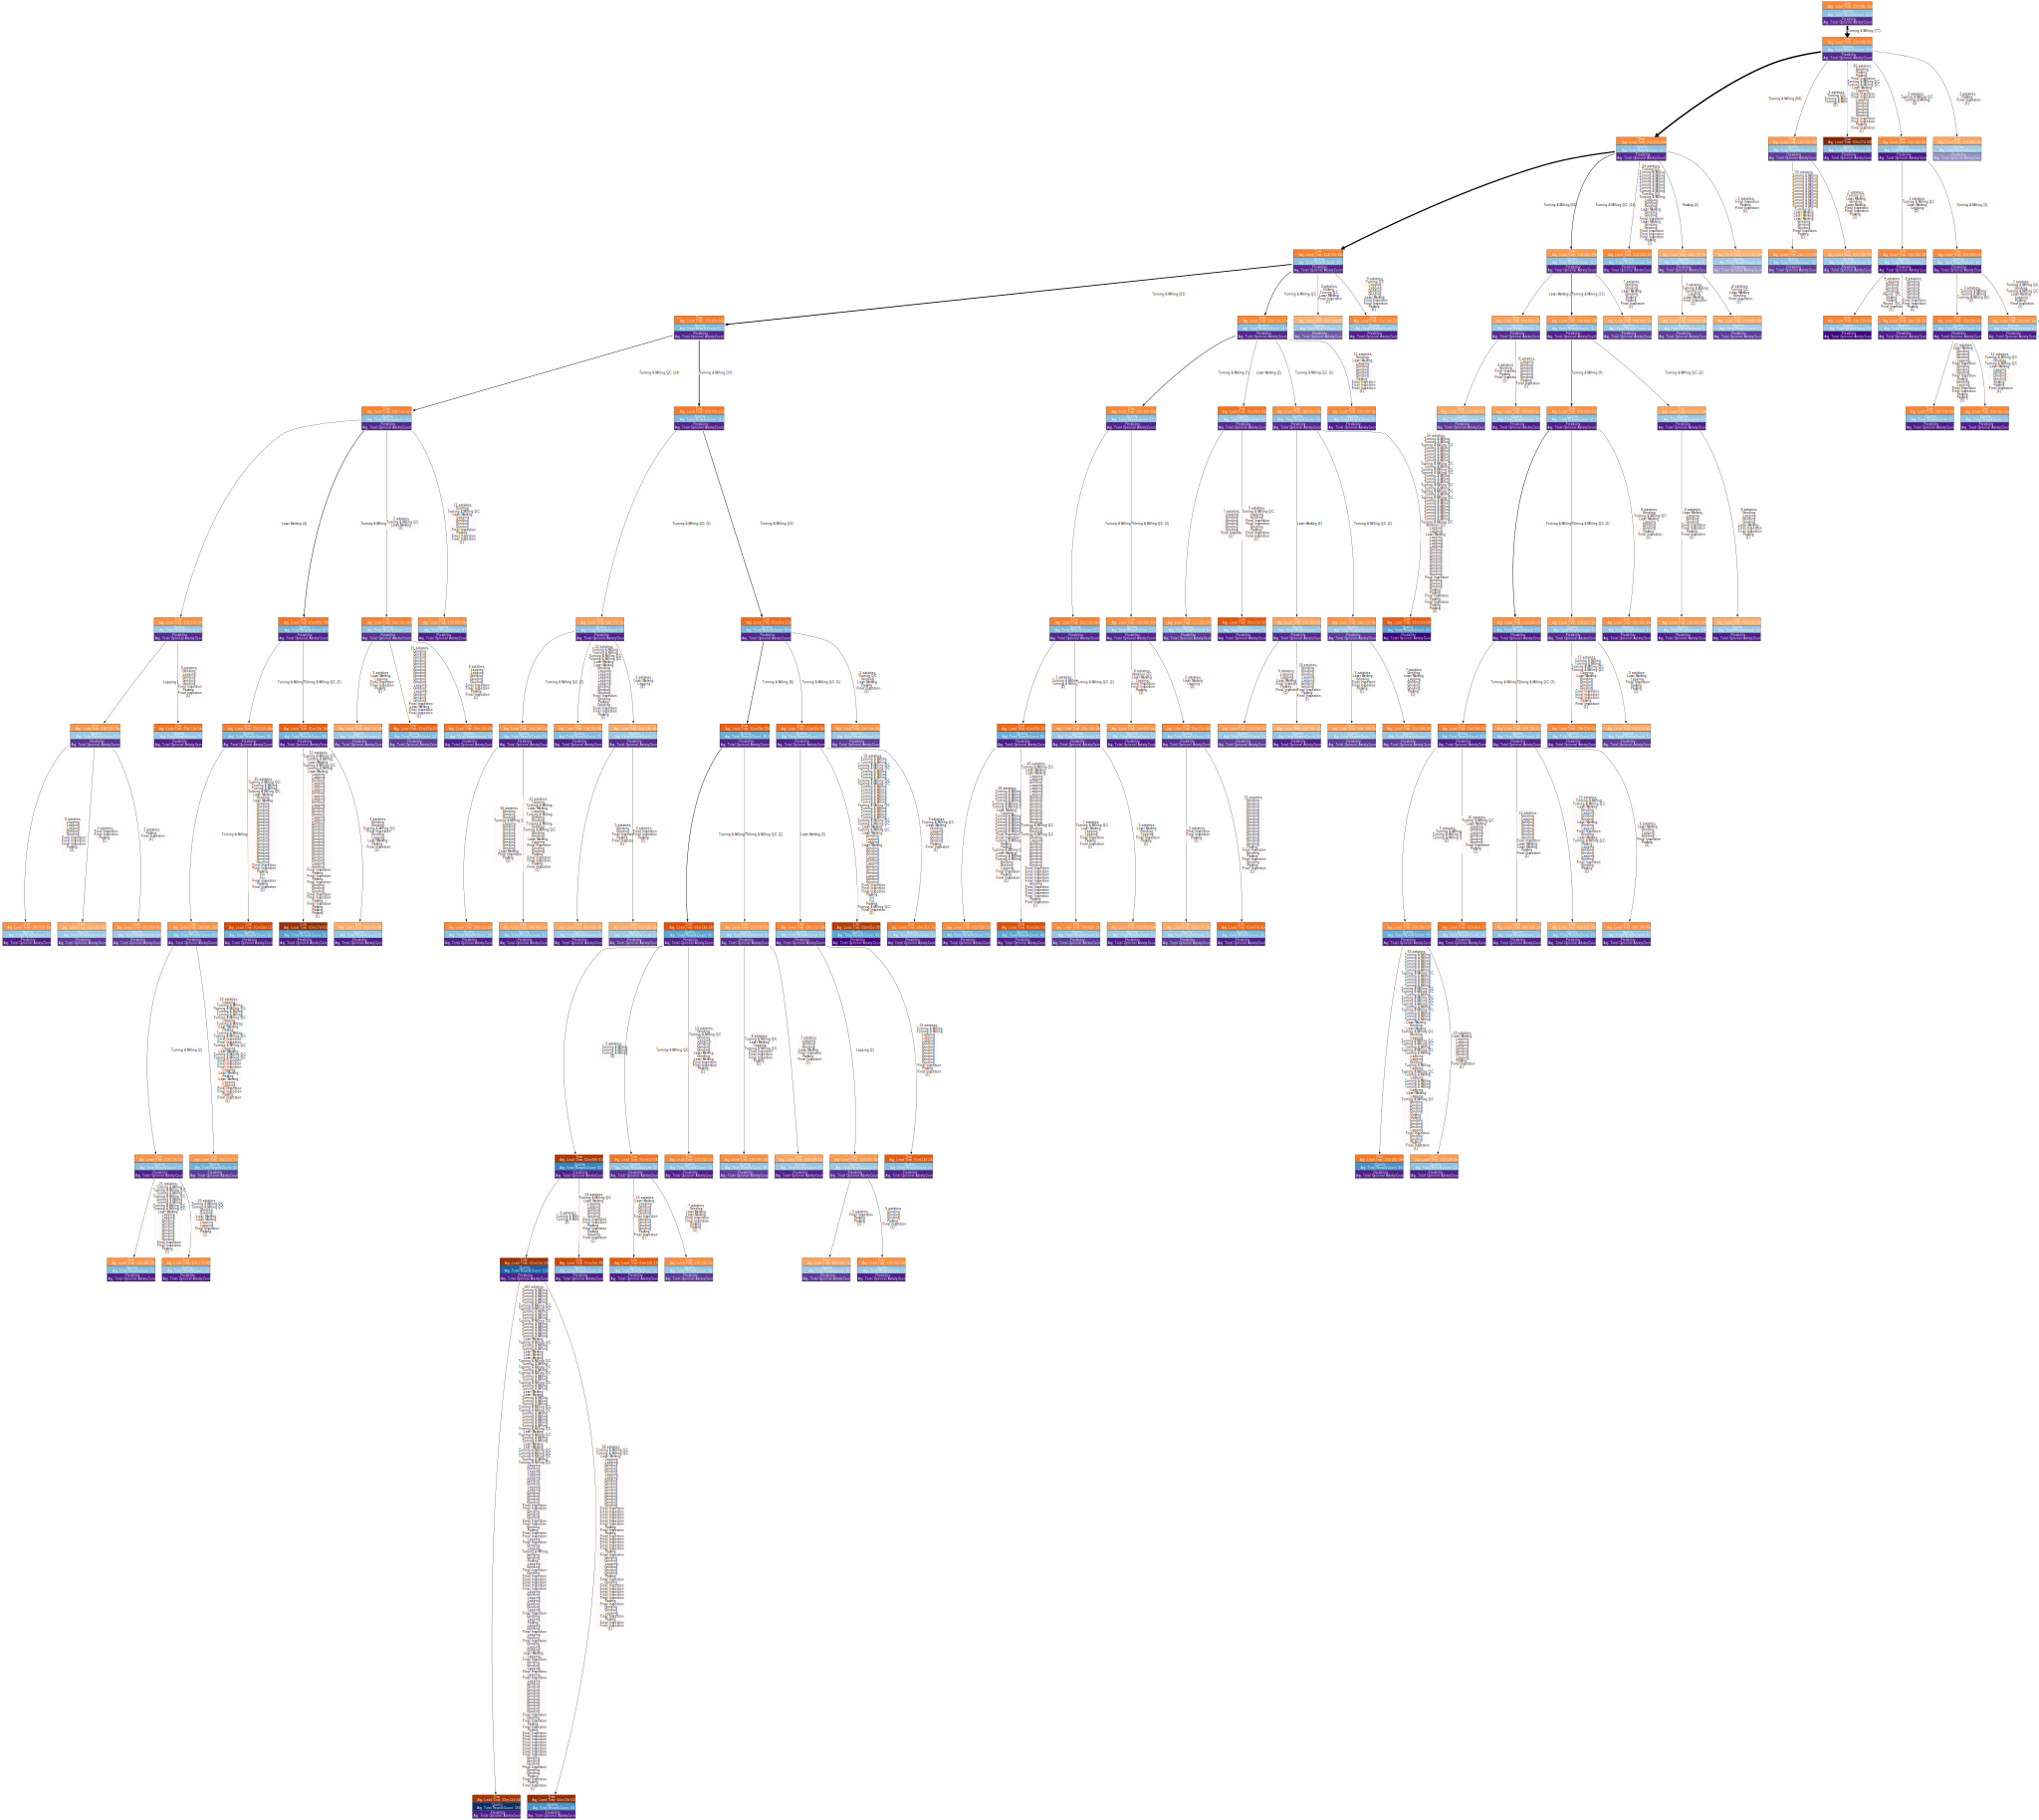

In [15]:
# By activating the 'group_activities' flag, linear paths are grouped
drt = mddrt.discover_multi_dimensional_drt(processed_log.copy(), group_activities = True, show_names = True)
mddrt.save_vis_multi_dimensional_drt(drt, file_path = 'drt_processed_log_autogroup', visualize_cost = False)
display(SVG(filename = 'drt_processed_log_autogroup.svg'))